# Monitor Convergence for "the Sun"

Applying multiple convergence checks for run 6, which adopted a floating Y and alpha. Up to now, we have monitored convergence by visually inspecting trace plots. It would be useful to know if convergence has been obtained using other metrics.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Defining convergence diagnostics

(1) trace plot, (2) acceptance fraction, (3) Gelman-Rubin diagnostic, (4) autocorrelation, (5) moving average. Others to consider: Geweke diagnostic, Raferty-Lewis diagnostic, Heidelberg-Welch diagnostic, ...

In [2]:
def tracePlot(chains, labels=None, truths=None):
    n_dim = chains.shape[2]
    
    fig, ax = plt.subplots(n_dim, 1, figsize=(8., 27.), sharex=True)
    ax[-1].set_xlabel('Iteration', fontsize=20.)
    for i in range(len(ax)):
        try:
            ax[i].set_ylabel(labels[i], fontsize=20.)
        except IndexError:
            pass
        ax[i].tick_params(which='major', axis='both', length=10., labelsize=16.)
        for j in range(len(chains)):
            try:
                ax[i].plot([0, len(chains[j,:,i])], [truths[i], truths[i]], '-', lw=4, dashes=(20., 10.), 
                           c='#B22222')
            except:
                pass
            ax[i].plot(chains[j,:,i], '-', lw=1, c='#0473B3', alpha=0.5)
    fig.tight_layout()

In [3]:
def GelmanRubin(chains, labels=None):
    n_chains = chains.shape[0]
    n_iter   = chains.shape[1]/2
    n_params = chains.shape[2]
    
    # take last n samples if total was 2n
    sample = chains[:,-n_iter:,:]
    
    # compute mean of intra-chain (within) variances
    W = np.mean(np.var(sample, axis=1), axis=0)
    
    # compute mean of inter-chain (between) variances
    chain_means = np.mean(sample, axis=1)
    mean_of_chain_means = np.mean(chain_means, axis=0)
        
    B = np.empty(n_params)
    for i in range(n_params):
        B[i] = np.sum((chain_means[:, i] - mean_of_chain_means[i])**2)*n_iter/(n_chains - 1.)
    
    # estimated variance (likely an over-estimate)
    Sigma_hat_2 = ((n_iter - 1.)*W + B)/n_iter
    
    # pooled posterior variance
    Var_hat = Sigma_hat_2 + B/(n_chains*n_iter)
    
    # compute potential scale reduction factor
    PSRF = np.sqrt(Var_hat/W)
    
    return W, B, Var_hat, PSRF

## Process samples

In [4]:
flatchain = np.genfromtxt('/Users/grefe950/Software/StarBay/interbay/logs/Sun_W0300_N0600_B0000.dat')
#flatchain = np.genfromtxt('/Users/grefe950/evolve/data/mltcal/model/chains/Sun_W0300_N0600_B0000.dat')
chains = flatchain.reshape(300, -1, 9)
labels=['Mass', '[Fe/H]', 'Y', 'log(Age)', 'Distance', 'alpha', 'log(Teff)', 'log(Fbol)', 'theta']
truths = [1.0, 0.00, 0.278, np.log10(4.568e9), 5.0, 1.884, np.log10(5779.), np.log10(1.286e-6), 1.860]

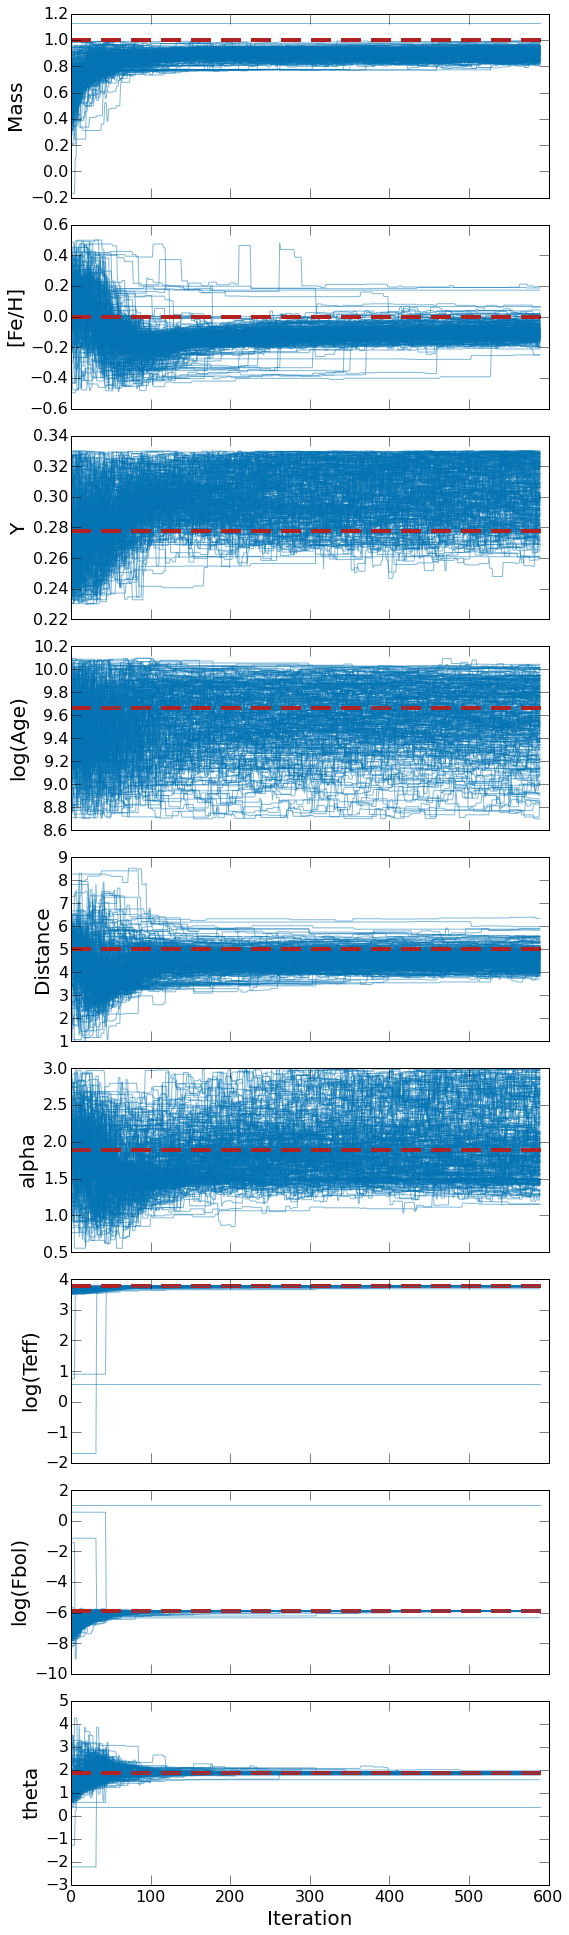

In [5]:
tracePlot(chains, labels=labels, truths=truths)

In [6]:
GelmanRubin(chains, labels=labels)

(array([  3.88200455e-04,   7.47025828e-04,   7.91417087e-05,
          7.53131848e-03,   2.38678166e-02,   3.94510910e-02,
          7.67963528e-06,   5.46826412e-05,   2.88593317e-04]),
 array([  0.38467614,   0.84478081,   0.07339414,  21.71978552,
         49.63979196,  47.46476961,   9.99067199,  47.32395751,   2.36052503]),
 array([ 0.00169522,  0.0036177 ,  0.0003285 ,  0.0813776 ,  0.19261829,
         0.20075121,  0.03398723,  0.16100943,  0.00831607]),
 array([  2.08970396,   2.20063815,   2.03733587,   3.28713042,
          2.8408115 ,   2.25579471,  66.5254116 ,  54.26263879,   5.36804151]))

Based on the trace plot, it seems as though the ensemble of chains have converged upon a solution. However, under the Gelman-Rubin diagnostic, the potential scale reduction factor is larger than one should like, that is, well above unity. 

It is therefore likely that we should continue running the chains further and continually apply a Gelman-Rubin diagnostic to assess the convergence of each parameter.

## Evolution of Potential Scale Reduction Factor


In [7]:
PSRF = np.empty((581, 9))
for i in range(10, 591):
    W, B, var_hat, PSRF[i - 10] = GelmanRubin(chains[:, :i, :]) # Note that GelmanRubin() trims the lower half

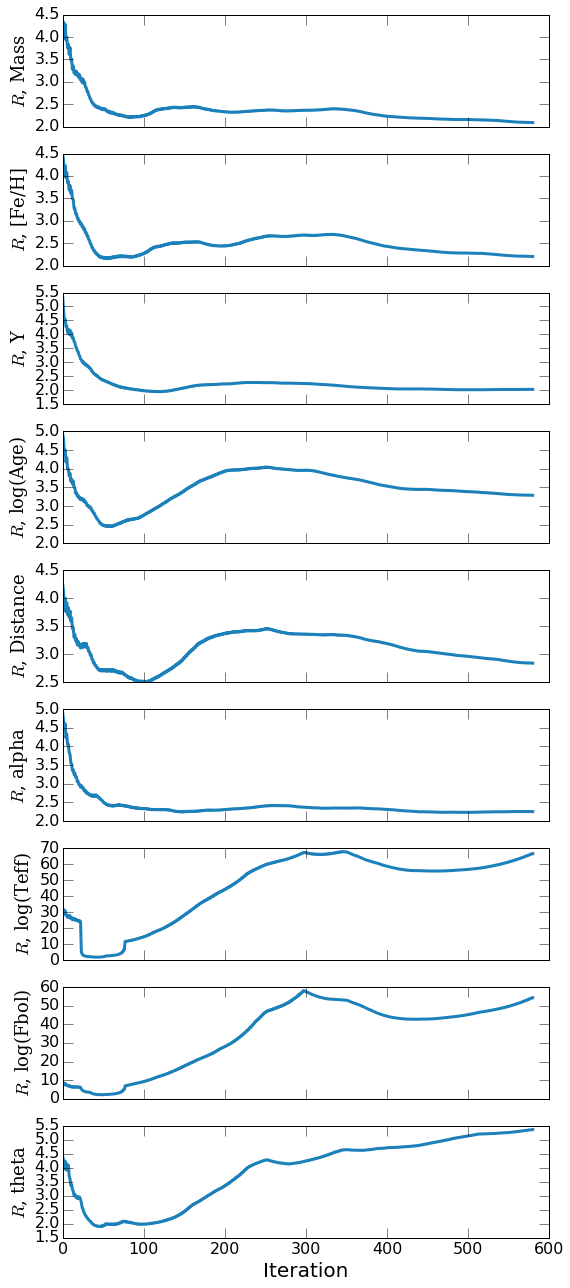

In [8]:
fig, ax = plt.subplots(9, 1, figsize=(8., 18.), sharex=True)
ax[-1].set_xlabel('Iteration', fontsize=20.)
for i in range(len(ax)):
    try:
        ax[i].set_ylabel('$R$, {:s}'.format(labels[i]), fontsize=18., family='serif')
    except IndexError:
        pass
    ax[i].tick_params(which='major', axis='both', length=10., labelsize=16.)
    ax[i].plot(PSRF[:,i], '-', lw=3, c='#0473B3', alpha=0.9)
    
fig.tight_layout()

There are clear issues with theta and Teff, which appear to possess a high level of variance, even after nearly 600 iterations. This can be traced to the presence of a couple outlier chains in the trace plots above. These chains have non-sense values for the effective temperature, bolometric flux, and angular diameter. Additional chains and interations should mitigate the presence of these outliers.

## Another Sun Run

In the interest of determining "optimal" MCMC parameters (number of walkers and iterations), I've started a new solar run. Instead of continuing the run used above (300 walkers, 600 iterations), I've started a new sampler with 1000 walkers over 500 steps. Depending on how well converged the final set of chains look, it may be worth decreasing the number of walkers and increasing the number of steps. 

Tracking the convergence of the above chains illustrated that convergence was slow, with the potential scale reduction factor slowly (albeit steadily) creeping toward acceptable values. 

In [9]:
new_flatchain = np.genfromtxt('/Users/grefe950/Software/StarBay/interbay/logs/Sun_W1000_N0500_B0000.dat')
new_chains = new_flatchain.reshape(1000, -1, 9)

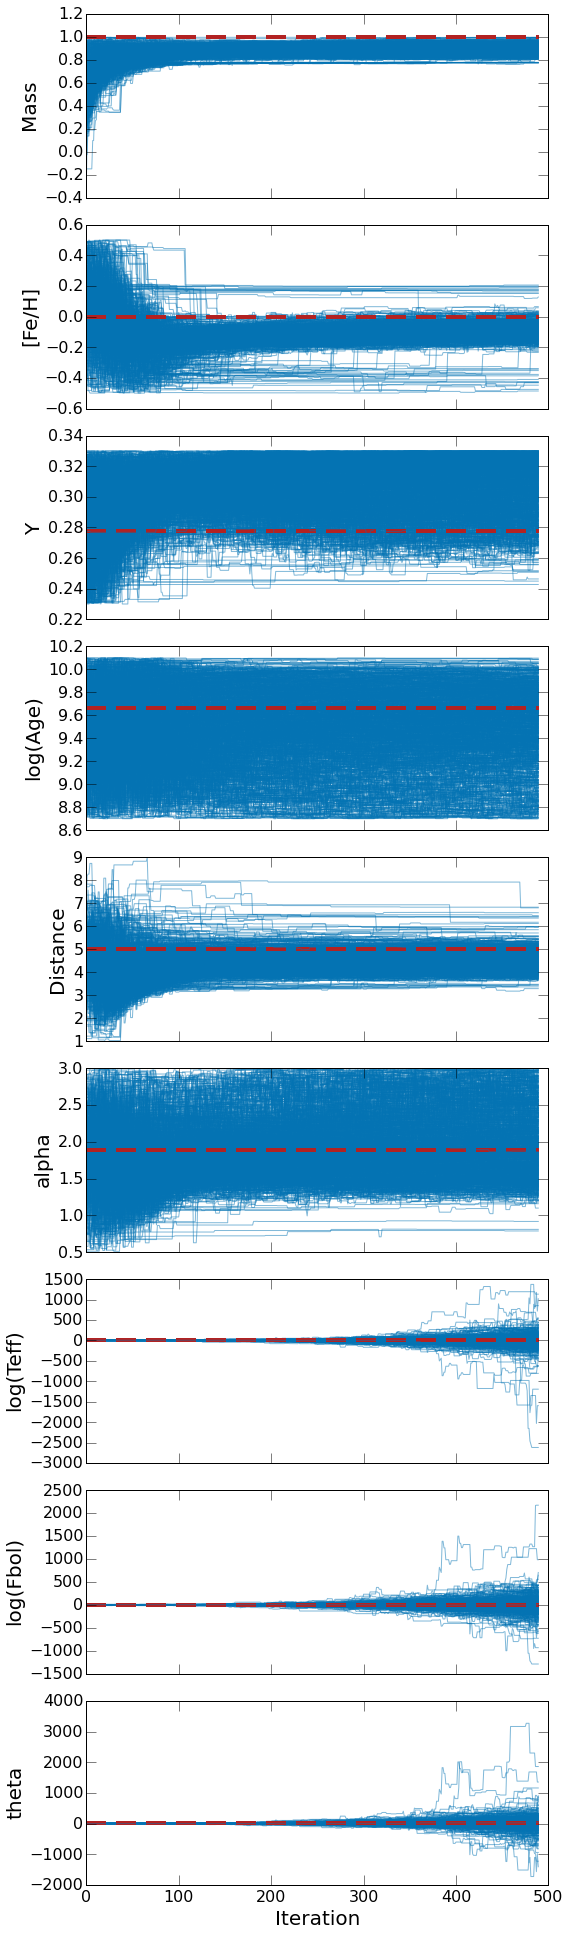

In [10]:
tracePlot(new_chains, labels=labels, truths=truths)

In [11]:
GelmanRubin(new_chains, labels=labels)

(array([  3.00644714e-04,   5.71600287e-04,   6.40183786e-05,
          7.49477493e-03,   1.80979598e-02,   3.04443901e-02,
          3.19341133e+03,   2.72328546e+03,   5.09612552e+03]),
 array([  3.33713781e-01,   8.92066662e-01,   6.72800092e-02,
          2.69895560e+01,   4.99953269e+01,   4.26581636e+01,
          5.92462074e+05,   6.16794632e+05,   1.07766582e+06]),
 array([  1.66287675e-03,   4.21399673e-03,   3.38643974e-04,
          1.17735798e-01,   2.22290712e-01,   2.04609196e-01,
          5.60100776e+03,   5.23221665e+03,   9.47835966e+03]),
 array([ 2.35181548,  2.71519408,  2.29995501,  3.96346446,  3.50465965,
         2.59244132,  1.32435878,  1.38610546,  1.36378696]))

In [12]:
new_PSRF = np.empty((481, 9))
for i in range(10, 491):
    W, B, var_hat, new_PSRF[i - 10] = GelmanRubin(new_chains[:, :i, :]) # Note that GelmanRubin() trims the lower half

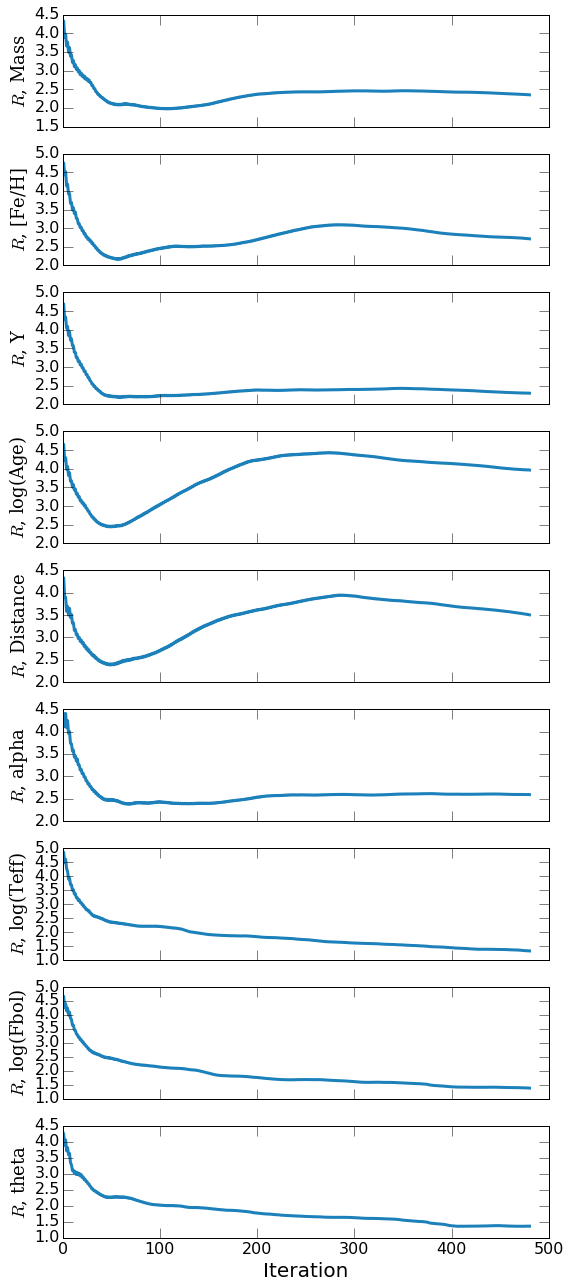

In [13]:
fig, ax = plt.subplots(9, 1, figsize=(8., 18.), sharex=True)
ax[-1].set_xlabel('Iteration', fontsize=20.)
for i in range(len(ax)):
    try:
        ax[i].set_ylabel('$R$, {:s}'.format(labels[i]), fontsize=18., family='serif')
    except IndexError:
        pass
    ax[i].tick_params(which='major', axis='both', length=10., labelsize=16.)
    ax[i].plot(new_PSRF[:,i], '-', lw=3, c='#0473B3', alpha=0.9)
    
fig.tight_layout()

## Yet Another Sun Run

This time with a large number of iterations, but smaller number of walkers (back to 300), since the previous experiment appears to indicate that the number of walkers is not an issue, but more the number of iterations, at least in terms of developing convergence among the full set of chains.

In [14]:
newer_flatchain = np.genfromtxt('/Users/grefe950/Software/StarBay/interbay/logs/Sun_W0300_N1500_B0000.dat')
newer_chains = newer_flatchain.reshape(300, -1, 9)

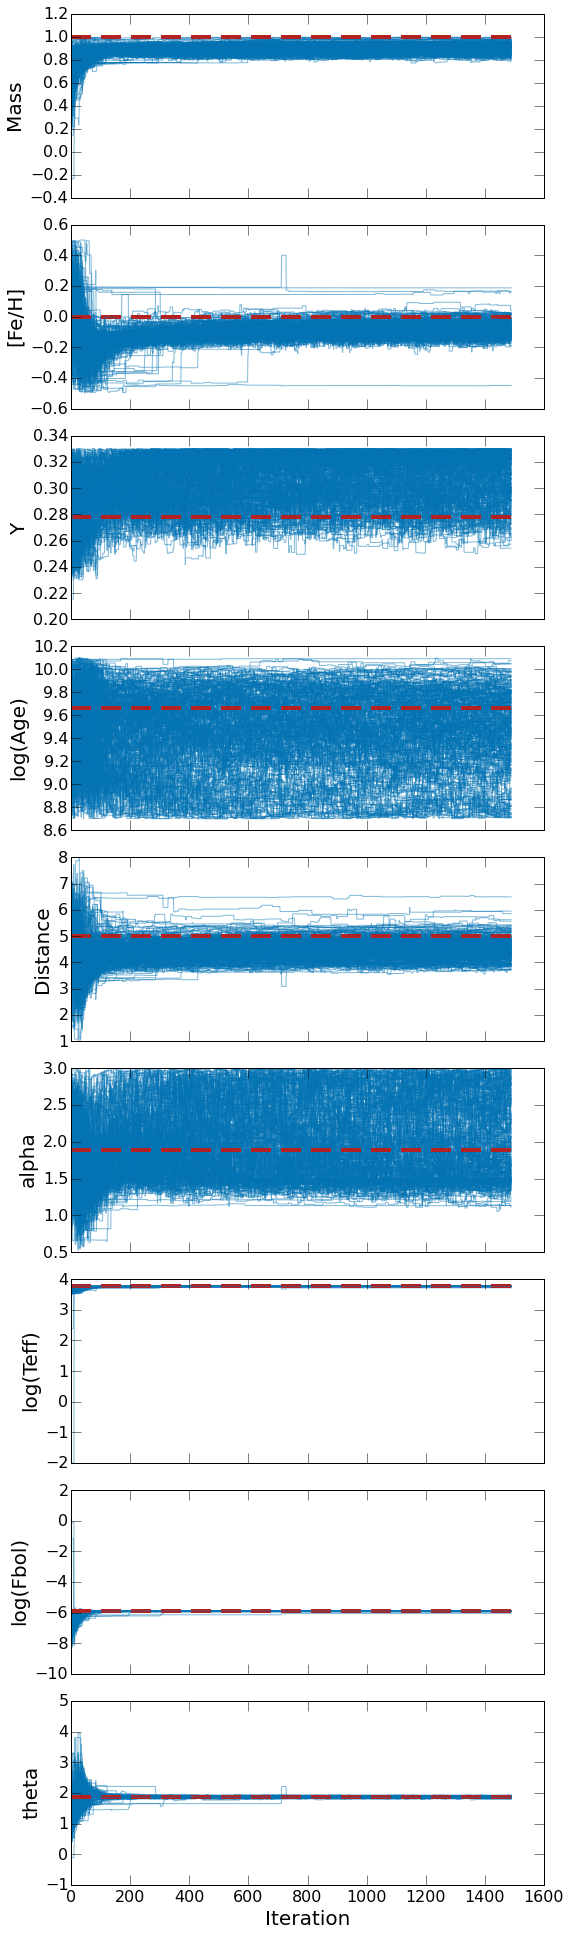

In [15]:
tracePlot(newer_chains, labels=labels, truths=truths)

In [16]:
GelmanRubin(newer_chains, labels=labels)

(array([  4.57884389e-04,   8.06555785e-04,   1.07857853e-04,
          1.62518549e-02,   3.06677250e-02,   6.28468629e-02,
          3.86742746e-06,   1.75327227e-05,   2.69547005e-04]),
 array([  8.72491590e-01,   1.83895940e+00,   1.61653096e-01,
          7.49826306e+01,   1.08714405e+02,   1.63626182e+02,
          1.09405776e-02,   9.93352893e-02,   1.18916236e-01]),
 array([  1.63230320e-03,   3.28210304e-03,   3.25420379e-04,
          1.17213359e-01,   1.77038354e-01,   2.83127072e-01,
          1.85965265e-05,   1.51289601e-04,   4.29336370e-04]),
 array([ 1.88808915,  2.01724617,  1.73698668,  2.68557378,  2.40266323,
         2.12250586,  2.19282931,  2.9375134 ,  1.2620646 ]))

In [17]:
newer_PSRF = np.empty((1490, 9))
for i in range(10, 1500):
    W, B, var_hat, newer_PSRF[i - 10] = GelmanRubin(newer_chains[:, :i, :]) # Note that GelmanRubin() trims the lower half

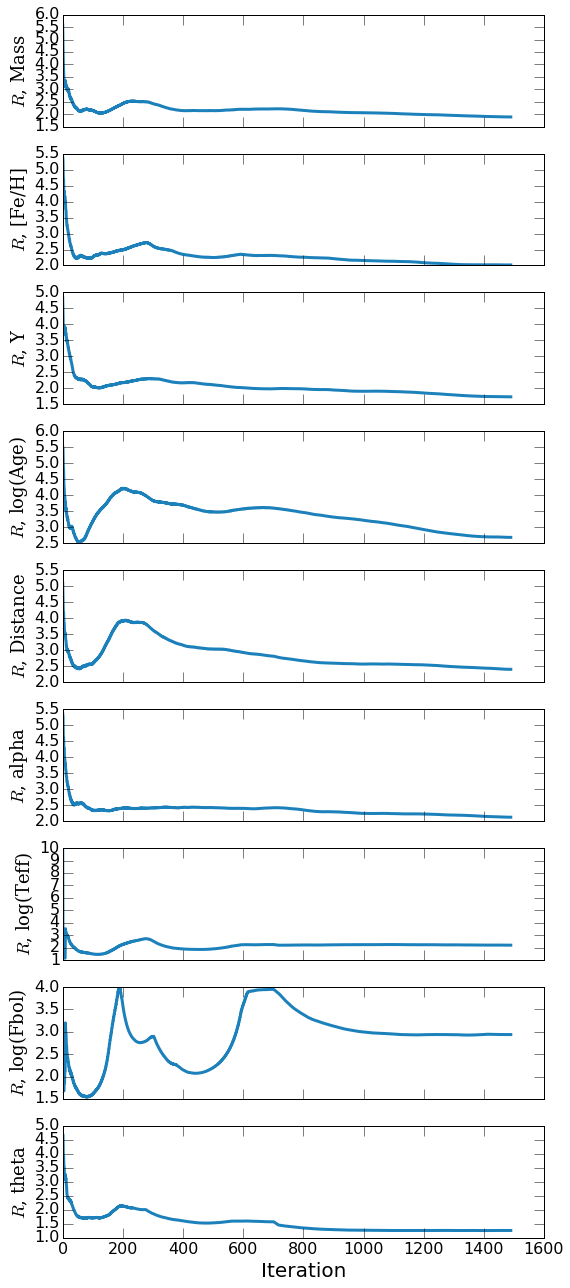

In [18]:
fig, ax = plt.subplots(9, 1, figsize=(8., 18.), sharex=True)
ax[-1].set_xlabel('Iteration', fontsize=20.)
for i in range(len(ax)):
    try:
        ax[i].set_ylabel('$R$, {:s}'.format(labels[i]), fontsize=18., family='serif')
    except IndexError:
        pass
    ax[i].tick_params(which='major', axis='both', length=10., labelsize=16.)
    ax[i].plot(newer_PSRF[:,i], '-', lw=3, c='#0473B3', alpha=0.9)
    
fig.tight_layout()

It is clear that pushing the potential reduction scale factor below 2.0 is exceptionally difficult in most sitautions, with convergence occurring very slowly. To estimate how many more iterations would be necessary to push $\hat{R}$ below 1.2, we perform a simple linear extrapolation based on the slope of $\hat{R}$ as a function of iternation number over the final 500 iterations.

In [19]:
slopes = (newer_PSRF[-1,:] - newer_PSRF[-500, :])/(len(newer_PSRF[:-1]) - len(new_PSRF[:-500]))
print (1.2 - newer_PSRF[-1,:])/slopes + len(new_PSRF[:-1])

[  6486.20032751   9049.27440351   5066.93537778   4520.65228608
  11377.59165263  11773.06271351  36726.52362087  40993.07241053
  14277.34499313]


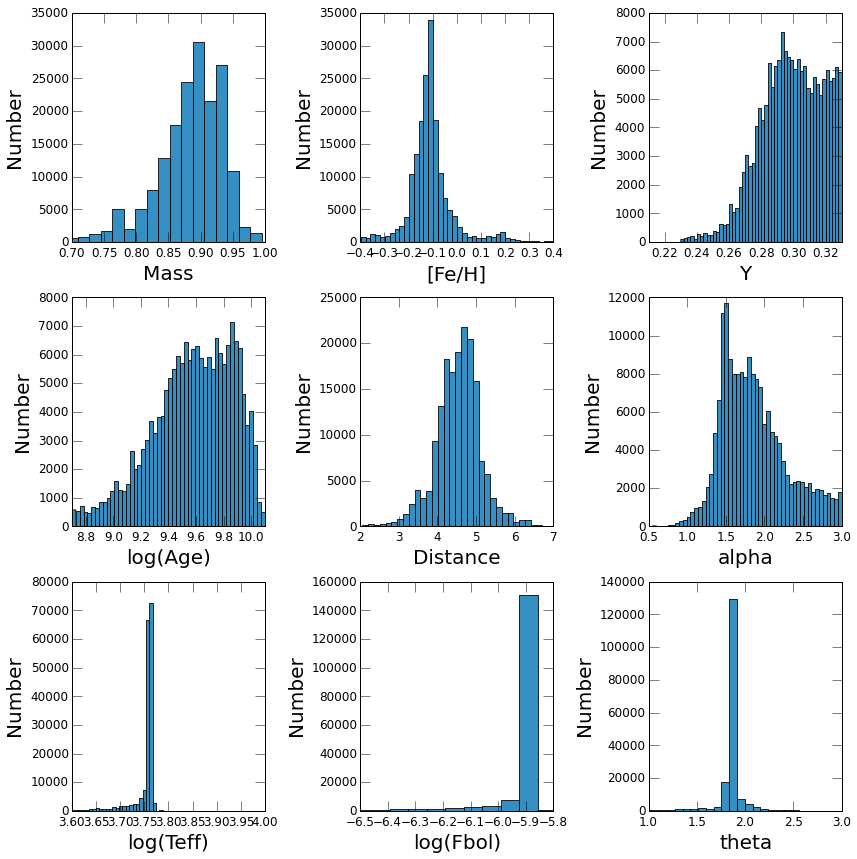

In [20]:
# remove spurious chains/points from the flatchain
newer_flatchain = newer_chains[:,-300:,:].reshape(-1, 9)
newer_flatchain = np.array([x for x in flatchain if x[0] > 0.0 and x[6] > 3.4])

fig, ax = plt.subplots(3, 3, figsize=(12, 12))

xlimits = [(0.7, 1.0), (-0.4, 0.4), (0.21, 0.33), (8.7, 10.1), (2, 7), (0.5, 3.0),
           (3.6, 4.0), (-6.5, -5.8), (1., 3.)]

for i in range(9):
    row = int(np.floor(i / 3.))
    col = i%3
    ax[row,col].set_xlabel(labels[i], fontsize=20.)
    ax[row,col].set_ylabel('Number', fontsize=20.)
    ax[row,col].set_xlim(xlimits[i])
    ax[row,col].tick_params(which='major', axis='both', length=10., labelsize=12.)
    ax[row,col].hist(newer_flatchain[:,i], bins=50., facecolor='#0473B3', alpha=0.8)
fig.tight_layout()

In [21]:
# compute statistics on the flattened chains
print '\n================'
print "\nW = 300, N = 600"
print "\nMeans"
print np.mean(flatchain, axis=0)
print "\nMedians"
print np.median(flatchain, axis=0)
print "\nStandard Deviations"
print np.std(flatchain, axis=0)
print '\n--'
print "\n50th Percentiles (Median)"
print np.percentile(flatchain, 50., axis=0)
print "\n16th Percentiles"
print np.percentile(flatchain, 16., axis=0)
print "\n84th Percentiles"
print np.percentile(flatchain, 84., axis=0)

print '\n================'
print "\nW = 1000, N = 500"
print "\nMeans"
print np.mean(new_flatchain, axis=0)
print "\nMedians"
print np.median(new_flatchain, axis=0)
print "\nStandard Deviations"
print np.std(new_flatchain, axis=0)
print '\n--'
print "\n50th Percentiles (Median)"
print np.percentile(new_flatchain, 50., axis=0)
print "\n16th Percentiles"
print np.percentile(new_flatchain, 16., axis=0)
print "\n84th Percentiles"
print np.percentile(new_flatchain, 84., axis=0)

print '\n================'
print "\nW = 300, N = 1500"
print "\nMeans"
print np.mean(newer_flatchain, axis=0)
print "\nMedians"
print np.median(newer_flatchain, axis=0)
print "\nStandard Deviations"
print np.std(newer_flatchain, axis=0)
print '\n--'
print "\n50th Percentiles (Median)"
print np.percentile(newer_flatchain, 50., axis=0)
print "\n16th Percentiles"
print np.percentile(newer_flatchain, 16., axis=0)
print "\n84th Percentiles"
print np.percentile(newer_flatchain, 84., axis=0)



W = 300, N = 600

Means
[ 0.8798998  -0.10911307  0.29881788  9.57303978  4.53612851  1.85911136
  3.73747207 -5.91307482  1.85182094]

Medians
[ 0.8907085  -0.1150486   0.29934026  9.60145299  4.5645845   1.79336997
  3.7595694  -5.89205135  1.86371555]

Standard Deviations
[ 0.06575607  0.10056315  0.01918498  0.29196716  0.61751117  0.42957267
  0.20510036  0.45519567  0.19481798]

--

50th Percentiles (Median)
[ 0.8907085  -0.1150486   0.29934026  9.60145299  4.5645845   1.79336997
  3.7595694  -5.89205135  1.86371555]

16th Percentiles
[ 0.8352832  -0.17492813  0.27916271  9.27716199  4.02763333  1.46337611
  3.74725121 -5.90847007  1.83443328]

84th Percentiles
[ 0.93280087 -0.0532867   0.32035907  9.87790925  5.01728003  2.29467129
  3.76321473 -5.88619763  1.89391452]


W = 1000, N = 500

Means
[ 0.87331826 -0.1114445   0.30272164  9.4943405   4.45475963  1.87567924
 -0.70770233  0.94369065  2.60694313]

Medians
[ 0.88568665 -0.1150515   0.3047721   9.52345507  4.44551136  1.

## Analysis

What messages can we take away from these experiments? First, one can easily not that our original set of walkers delivered a very robust solution. It therefore appear that the walkers were adequately sampling from the target distribution. Overall, we did not recover the mass of the Sun, which is almost certainly a consequence of the fact that our grid tops out anywhere between 0.95 and 1.0 solar mass. Not surprisingly, then, the simulation attempted to produce a star with a hotter effective temperature and larger bolometric flux by other means, namely the increasing of the helium abundance, lowering of the overall metallicity, and estimating a closer distance. 

However, it's interesting to note that the simulations did not perform poorly. The solar age is nearly recovered by the simulation, with a final age estimate of $4.0^{+3.6}_{-2.1}$ Gyr, with the errors quoted being the 68% confidence interval from the posterior distribution (16th and 84th percentiles from the cumulative distribution). The solar helium abundance is also partially recovered, despite the simulations preference for higher initial helium contents to compensate for a poor grid extension at higher masses. The solar-calibrated helium abundance is $0.276$ dex, whereas our simulation suggests $0.30^{+0.03}_{-0.02}$ dex. Agreement is tenuous, and perhaps expected given the fairly narrow range of permitted helium abundances.

We also observe that the convective mixing length parameter is reproduced. This should be interpretted cautiously, since the distribution, as displayed in the histograms above, peaks around 1.5 with a small bump in the distribution thereafter (centered on the median). How, precisely, to treat the analysis of posterior distribution for the mixing length is an open question, in my mind. 

---

### References

Brooks & Gelman 1998, _Journal of Computational and Graphical Statistics_, __7__, 434 &ndash; 455; [General Methods for Monitoring Convergence of Iterative Simulations](http://www.jstor.org/stable/1390675?origin=crossref)

Gelman & Rubin 1992, _Statistical Science_, __7__, 457 &ndash; 511; [Inference from Iterative Simulation Using Multiple Sequences](https://projecteuclid.org/euclid.ss/1177011136)